## Perfiles de edad y metalicidad

### Calculo los perfiles de edad y metalicidad integrados en anillos.

In [1]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import make_profiles as mpf

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(14):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    FeH_ = met[amask,8]/met[amask,0]
    FeH  = FeH_/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit2, = np.where(rn < rgal)

    age_ = age[limit2]

    #     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    FeH   = FeH[limit2]

    R = np.sqrt(x_str**2 + y_str**2)

    mask,  = np.where(FeH>0)

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    nbin = 15
    
    met_profile = mpf.profile_eqn(R[mask],np.log10(FeH[mask]),nbin)
    np.savetxt('../_data/met_profile/met_eqn_prof_sh'+str('%s'%Id)+'.dat',
               np.column_stack(met_profile), 
               delimiter=' ', 
               header='Perfiles con bines equal number \n median metallicity')
    
    met_profile = mpf.profile_log(R[mask],np.log10(FeH[mask]),nbin)
    np.savetxt('../_data/met_profile/met_log_prof_sh'+str('%s'%Id)+'.dat',
               np.column_stack(met_profile), 
               delimiter=' ', 
               header='Perfiles con bines log \n median metallicity percentile25 percentile 75')

    age_profile = mpf.profile_eqn(R[mask],age_[mask],nbin) #uso el mismo codigo que la metalicidad porque solo hace el bineado
    np.savetxt('../_data/age_profile/age_eqn_prof_sh'+str('%s'%Id)+'.dat',
               np.column_stack(age_profile), 
               delimiter=' ', 
               header='Perfiles con bines equal number \n median age')
    
    age_profile = mpf.profile_log(R[mask],age_[mask],nbin)
    np.savetxt('../_data/age_profile/age_log_prof_sh'+str('%s'%Id)+'.dat',
               np.column_stack(age_profile), 
               delimiter=' ', 
               header='Perfiles con bines log \n median age percentile25 percentile 75')

   

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031


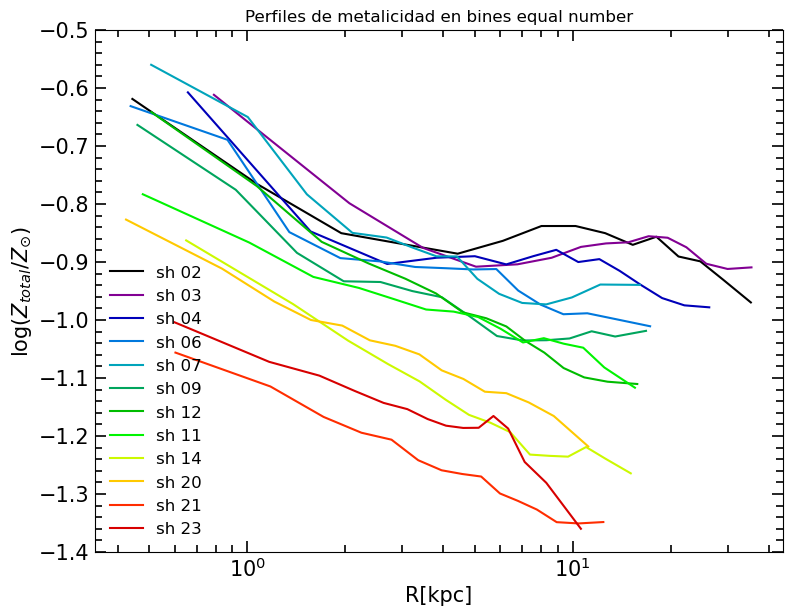

In [3]:
import numpy as np
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    data = np.loadtxt('../_data/met_profile/met_eqn_prof_sh'+str('%s'%Id)+'.dat')

    med = data[:,0]
    FeH = data[:,1]

    ax.plot(med,FeH,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-1.4,-0.5)
ax.set_xscale('log')
ax.set_ylabel(r'log($Z_{total}/Z_{\odot}$)',fontsize=15)
ax.set_xlabel('R[kpc]',fontsize=15)
ax.set_title('Perfiles de metalicidad en bines equal number')
ax.legend(fontsize=12,frameon=False)

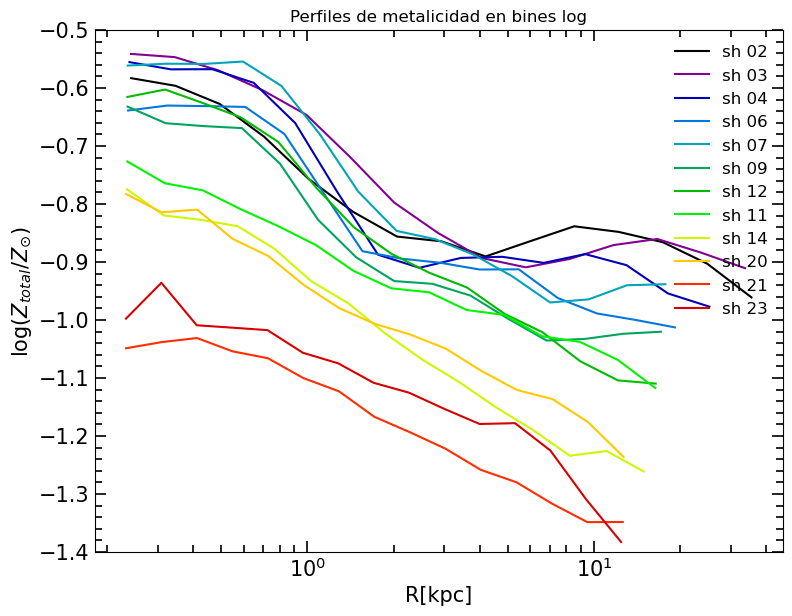

In [5]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    data = np.loadtxt('../_data/met_profile/met_log_prof_sh'+str('%s'%Id)+'.dat')

    med = data[:,0]
    FeH = data[:,1]

    ax.plot(med,FeH,'-', label='sh '+Id, color = colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-1.4,-0.5)
ax.set_xscale('log')
ax.set_ylabel(r'log($Z_{total}/Z_{\odot}$)',fontsize=15)
ax.set_xlabel('R[kpc]',fontsize=15)
ax.set_title('Perfiles de metalicidad en bines log')
ax.legend(fontsize=12,frameon=False)

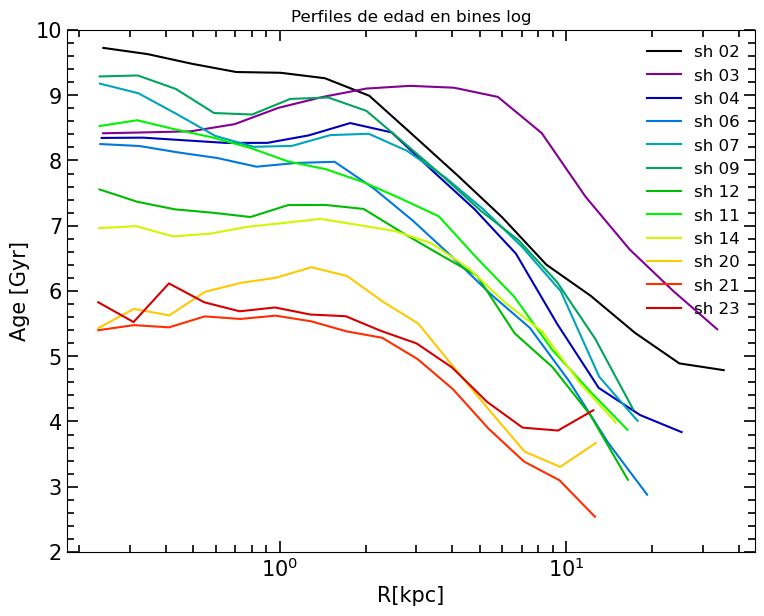

In [11]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    data = np.loadtxt('../_data/age_profile/age_log_prof_sh'+str('%s'%Id)+'.dat')

    med = data[:,0]
    age = data[:,1]

    ax.plot(med,age,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(2,10)
ax.set_xscale('log')
ax.set_ylabel(r'Age [Gyr]',fontsize=15)
ax.set_xlabel('R[kpc]',fontsize=15)
ax.set_title('Perfiles de edad en bines log')
ax.legend(fontsize=12,frameon=False)

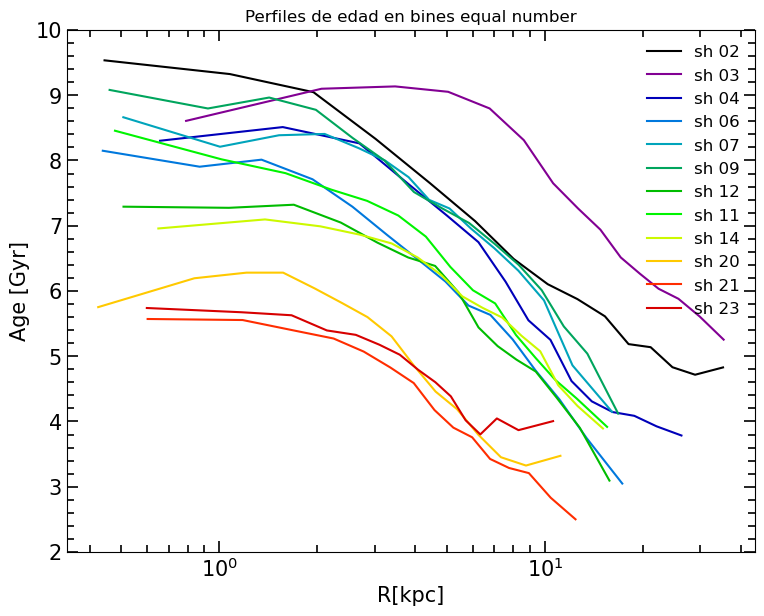

In [10]:
import matplotlib.pyplot as plt
import numpy as np

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    data = np.loadtxt('../_data/age_profile/age_eqn_prof_sh'+str('%s'%Id)+'.dat')

    med = data[:,0]
    age = data[:,1]

    ax.plot(med,age,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(2,10)
ax.set_xscale('log')
ax.set_ylabel(r'Age [Gyr]',fontsize=15)
ax.set_xlabel('R[kpc]',fontsize=15)
ax.set_title('Perfiles de edad en bines equal number')
ax.legend(fontsize=12,frameon=False)